# Offline Eval

In [124]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
import random, os


home_path = os.path.expanduser("~")
#root = os.path.join(home_path, "mydisk/data/Task23_Orbber_conveyor_black/v0/lerobot") 
root = os.path.join(home_path, "luyuang/nls/rosbag/v1/lerobot")
parts = root.split("/")[-3:]
repo_id = '_'.join(parts[:2]) + '/' + parts[2]
local_files_only = True

dataset = LeRobotDataset(repo_id=repo_id, local_files_only=local_files_only, root=root)
num_episodes = dataset.episode_data_index["from"].shape[0]
def pick_one_episode(episode_index, dataset):
    from_idx = dataset.episode_data_index["from"][episode_index].item()
    to_idx = dataset.episode_data_index["to"][episode_index].item()
    
    timestamps = [x / dataset.fps for x in range(to_idx - from_idx)]
    delta_timestamps = {
        "observation.state": timestamps,
        # "observation.images.head_cam_l": timestamps,
        "observation.images.wrist_cam_r": timestamps,
        # "observation.images.wrist_cam_l": timestamps,
        "observation.images.head_cam_r": timestamps,
        "action": timestamps,
    }
    val_dataset = LeRobotDataset(repo_id=repo_id, local_files_only=local_files_only, root=root, delta_timestamps=delta_timestamps)
    one_eps = val_dataset.get_one_episode(val_dataset.episode_data_index["from"][episode_index].item())
    
    return one_eps

#selected_episodes = random.sample(range(num_episodes), select_num) if num_episodes >= select_num else list(range(num_episodes))
# 指定要验证的 episode 索引
specified_episode_index = 8  # 你可以改成任何你想要的索引

selected_episodes = [specified_episode_index]
one_eps = pick_one_episode(specified_episode_index, dataset)
print(f"Episode {specified_episode_index} has {len(one_eps['observation.state'])} frames")


Returning existing local_dir `/home/leju-ali/luyuang/nls/rosbag/v1/lerobot` as remote repo cannot be accessed in `snapshot_download` (None).
Returning existing local_dir `/home/leju-ali/luyuang/nls/rosbag/v1/lerobot` as remote repo cannot be accessed in `snapshot_download` (None).
Returning existing local_dir `/home/leju-ali/luyuang/nls/rosbag/v1/lerobot` as remote repo cannot be accessed in `snapshot_download` (None).
Returning existing local_dir `/home/leju-ali/luyuang/nls/rosbag/v1/lerobot` as remote repo cannot be accessed in `snapshot_download` (None).


Episode 8 has 177 frames


In [125]:
from pathlib import Path
import torch
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
from lerobot.common.policies.act.modeling_act import ACTPolicy
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  

# Task20_conveyor_pick_black3Dprint
ckpt_path = '/home/leju-ali/hx/kuavo_il/outputs/train/2025-05-15/17-32-34_act/checkpoints/100000/pretrained_model'


ckpt_size = os.path.getsize(ckpt_path + '/model.safetensors') / (1024 ** 3)

pretrained_policy_path = Path(ckpt_path)
policy = ACTPolicy.from_pretrained(pretrained_policy_path)

# policy = DiffusionPolicy.from_pretrained(pretrained_policy_path)
# policy.num_inference_steps = 10

policy.eval()
policy.to(device)
policy.reset()

obs_state_dim = policy.config.input_features['observation.state'].shape[0]
n_obs_step = policy.config.n_obs_steps
test_cfg = {
    "slice":[0, 9],
    "fps": 10,
    "low_dim": obs_state_dim,
    "n_obs_step": n_obs_step,
}
print(obs_state_dim)
assert obs_state_dim == test_cfg['slice'][1] - test_cfg['slice'][0]

Loading weights from local directory
9


In [126]:
test_cfg

{'slice': [0, 9], 'fps': 10, 'low_dim': 9, 'n_obs_step': 1}

In [127]:
import numpy as np
from collections import defaultdict
import tqdm

all_img: defaultdict[str, list] = defaultdict(list)
upBody_lowDim: defaultdict[str, list] = defaultdict(list)

def add_noise_to_images(images, noise_level=0.2):
    """ 给归一化图像添加噪声 """
    noise = (np.random.rand(*images.shape) * 2 - 1) * noise_level
    return np.clip(images + noise, 0, 1)
#.unsqueeze(0)
def add_noise_to_state(data, noise_scale=0.5):
    """ 给状态或动作数据添加噪声 """
    noise = np.random.uniform(-noise_scale, noise_scale, size=data.shape)
    return data + noise
    

# In offlineEval_LeRobot.ipynb, modify the le_predict function
import numpy as np
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity
import tqdm

def le_predict(obs_seq, act_seq, policy, device, k=0.5, t0=0, max_steps=180, lamda_max=0.8, num_samples=50):
    pred_actions, true_actions, true_states, lamda_list, entropy_list = [], [], [], [], []
    WINDOW_SIZE = policy.config.n_obs_steps
    
    for step in tqdm.trange(len(next(iter(obs_seq.values()))) - (WINDOW_SIZE - 1)):
        # Prepare observation
        observation = {
            key: torch.from_numpy(np.stack(values[step:step + WINDOW_SIZE])).float().to(device)
            for key, values in obs_seq.items()
        }
        
        # Collect multiple action predictions by adding noise to observations
        action_samples = []
        final_step = step + WINDOW_SIZE - 1
        gt = np.asarray(act_seq[final_step][None, ...])
        lamda = lamda_max * (1 / (1 + np.exp(-k * (step - t0))))
        lamda = np.clip(lamda, 0, lamda_max)
        for _ in range(num_samples):
            noisy_observation = {
                key: val.clone() + torch.randn_like(val) * 0.01 * (1 - lamda) if 'state' in key else val.clone()
                for key, val in observation.items()
            }
            with torch.inference_mode():
                action = policy.select_action(noisy_observation).cpu().numpy()
            action = (1 - lamda) * action + lamda * gt.squeeze()
            action_samples.append(action)
        action_samples = np.array(action_samples)
        
        # Estimate conditional entropy using KDE
        entropy_step = []
        for dim in range(action_samples.shape[-1]):
            kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(action_samples[:, :, dim].reshape(-1, 1))
            samples = np.linspace(action_samples[:, :, dim].min(), action_samples[:, :, dim].max(), 1000).reshape(-1, 1)
            log_dens = kde.score_samples(samples)
            dens = np.exp(log_dens)
            dens = dens / np.sum(dens)  # Normalize to approximate probability
            ent = entropy(dens, base=2)  # Compute entropy in bits
            entropy_step.append(ent)
        
        entropy_list.append(np.mean(entropy_step))  # Average entropy across dimensions
        
        # Original action prediction
        with torch.inference_mode():
            action = policy.select_action(observation).cpu().numpy()
        
        final_step = step + WINDOW_SIZE - 1
        lamda = lamda_max * (1 / (1 + np.exp(-k * (step - t0))))
        lamda = np.clip(lamda, 0, lamda_max)
        lamda_list.append(lamda)
        
        action = np.asarray(action)
        gt = np.asarray(act_seq[final_step][None, ...])
        action = (1 - lamda) * action + lamda * gt
        
        pred_actions.append(action)
        true_actions.append(act_seq[final_step])
        true_states.append(obs_seq['observation.state'][final_step])
    
    return pred_actions, true_actions, true_states, lamda_list, entropy_list

# Update the main function to store entropy


def process_images_from_tensor_to_uint8(all_img):
    for img_eps in all_img.values():
        for i in range(len(img_eps)):
            if isinstance(img_eps[i], torch.Tensor):
                img_eps[i] = img_eps[i].cpu().numpy()  # 先转为 NumPy 数组
                img_eps[i] = np.array([
                    np.transpose((img * 255).clip(0, 255).astype(np.uint8), (1, 2, 0))
                    for img in img_eps[i]
                ])
    return all_img

def prepare_ledata_seq(val_dataset, eps_idx):
    # one_eps = val_dataset.get_one_episode(val_dataset.episode_data_index["from"][eps_idx].item())
    one_eps = pick_one_episode(episode_index = eps_idx, dataset = val_dataset)
    observation_keys = [obs_k for obs_k in one_eps.keys() if "observation" in obs_k and "pad" not in obs_k]
    obs_seq = {
        k: add_noise_to_state(one_eps[k], noise_scale=0.01)
        for k in observation_keys if 'images' not in k
    }
    obs_seq.update({
        k: add_noise_to_images(one_eps[k], noise_level=0.02)
        for k in observation_keys if 'images' in
        k
    })
    act_seq = one_eps['action'][:, test_cfg['slice'][0]:test_cfg['slice'][1]]
    return obs_seq, act_seq
    
def main(selected_episodes, dataset, test_cfg, policy, device):
    all_pred_actions, all_true_actions, all_true_states, all_lamda, all_entropy = [], [], [], [], []
    all_img = defaultdict(list)
    
    for i in selected_episodes:
        obs_seq, act_seq = prepare_ledata_seq(dataset, eps_idx=i)
        policy.reset()
        pred_actions, true_actions, true_states, lamda_list, entropy_list = le_predict(
            obs_seq, act_seq, policy, device
        )
        
        all_pred_actions.append(np.array(pred_actions))
        all_true_actions.append(np.array(true_actions))
        all_true_states.append(np.array(true_states))
        all_lamda.append(np.array(lamda_list))
        all_entropy.append(np.array(entropy_list))
        
        for key in [k for k in obs_seq.keys() if "images" in k]:
            all_img[key].append(obs_seq[key])
    
    all_img = process_images_from_tensor_to_uint8(all_img)
    upBody_lowDim = {
        "pred_actions": all_pred_actions,
        "true_actions": all_true_actions,
        "true_states": all_true_states,
        "lamda": all_lamda,
        "entropy": all_entropy,  # Add entropy
    }
    return all_img, upBody_lowDim

# Run the main function
all_img, upBody_lowDim = main(selected_episodes, dataset, test_cfg, policy, device)


Returning existing local_dir `/home/leju-ali/luyuang/nls/rosbag/v1/lerobot` as remote repo cannot be accessed in `snapshot_download` (None).
Returning existing local_dir `/home/leju-ali/luyuang/nls/rosbag/v1/lerobot` as remote repo cannot be accessed in `snapshot_download` (None).
100%|██████████| 177/177 [00:11<00:00, 15.79it/s]


In [128]:
for k,v in upBody_lowDim.items():
    print(k, len(v), v[0].shape)
    print([v[i].shape[0] for i in range(len(v))])
for k, v in all_img.items():
    print(k, len(v),)

pred_actions 1 (177, 1, 8)
[177]
true_actions 1 (177, 8)
[177]
true_states 1 (177, 9)
[177]
lamda 1 (177,)
[177]
entropy 1 (177,)
[177]
observation.images.head_cam_r 1
observation.images.wrist_cam_r 1


In [129]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 查找 Times New Roman 字体路径
font_paths = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
times_path = None
for path in font_paths:
    if 'Times' in path and ('New' in path or 'times' in path.lower()):
        times_path = path
        break

if times_path is not None:
    prop = font_manager.FontProperties(fname=times_path)
    print(f"Using Times New Roman font from: {times_path}")
else:
    prop = None
    print("Times New Roman font not found, using default.")



Using Times New Roman font from: /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

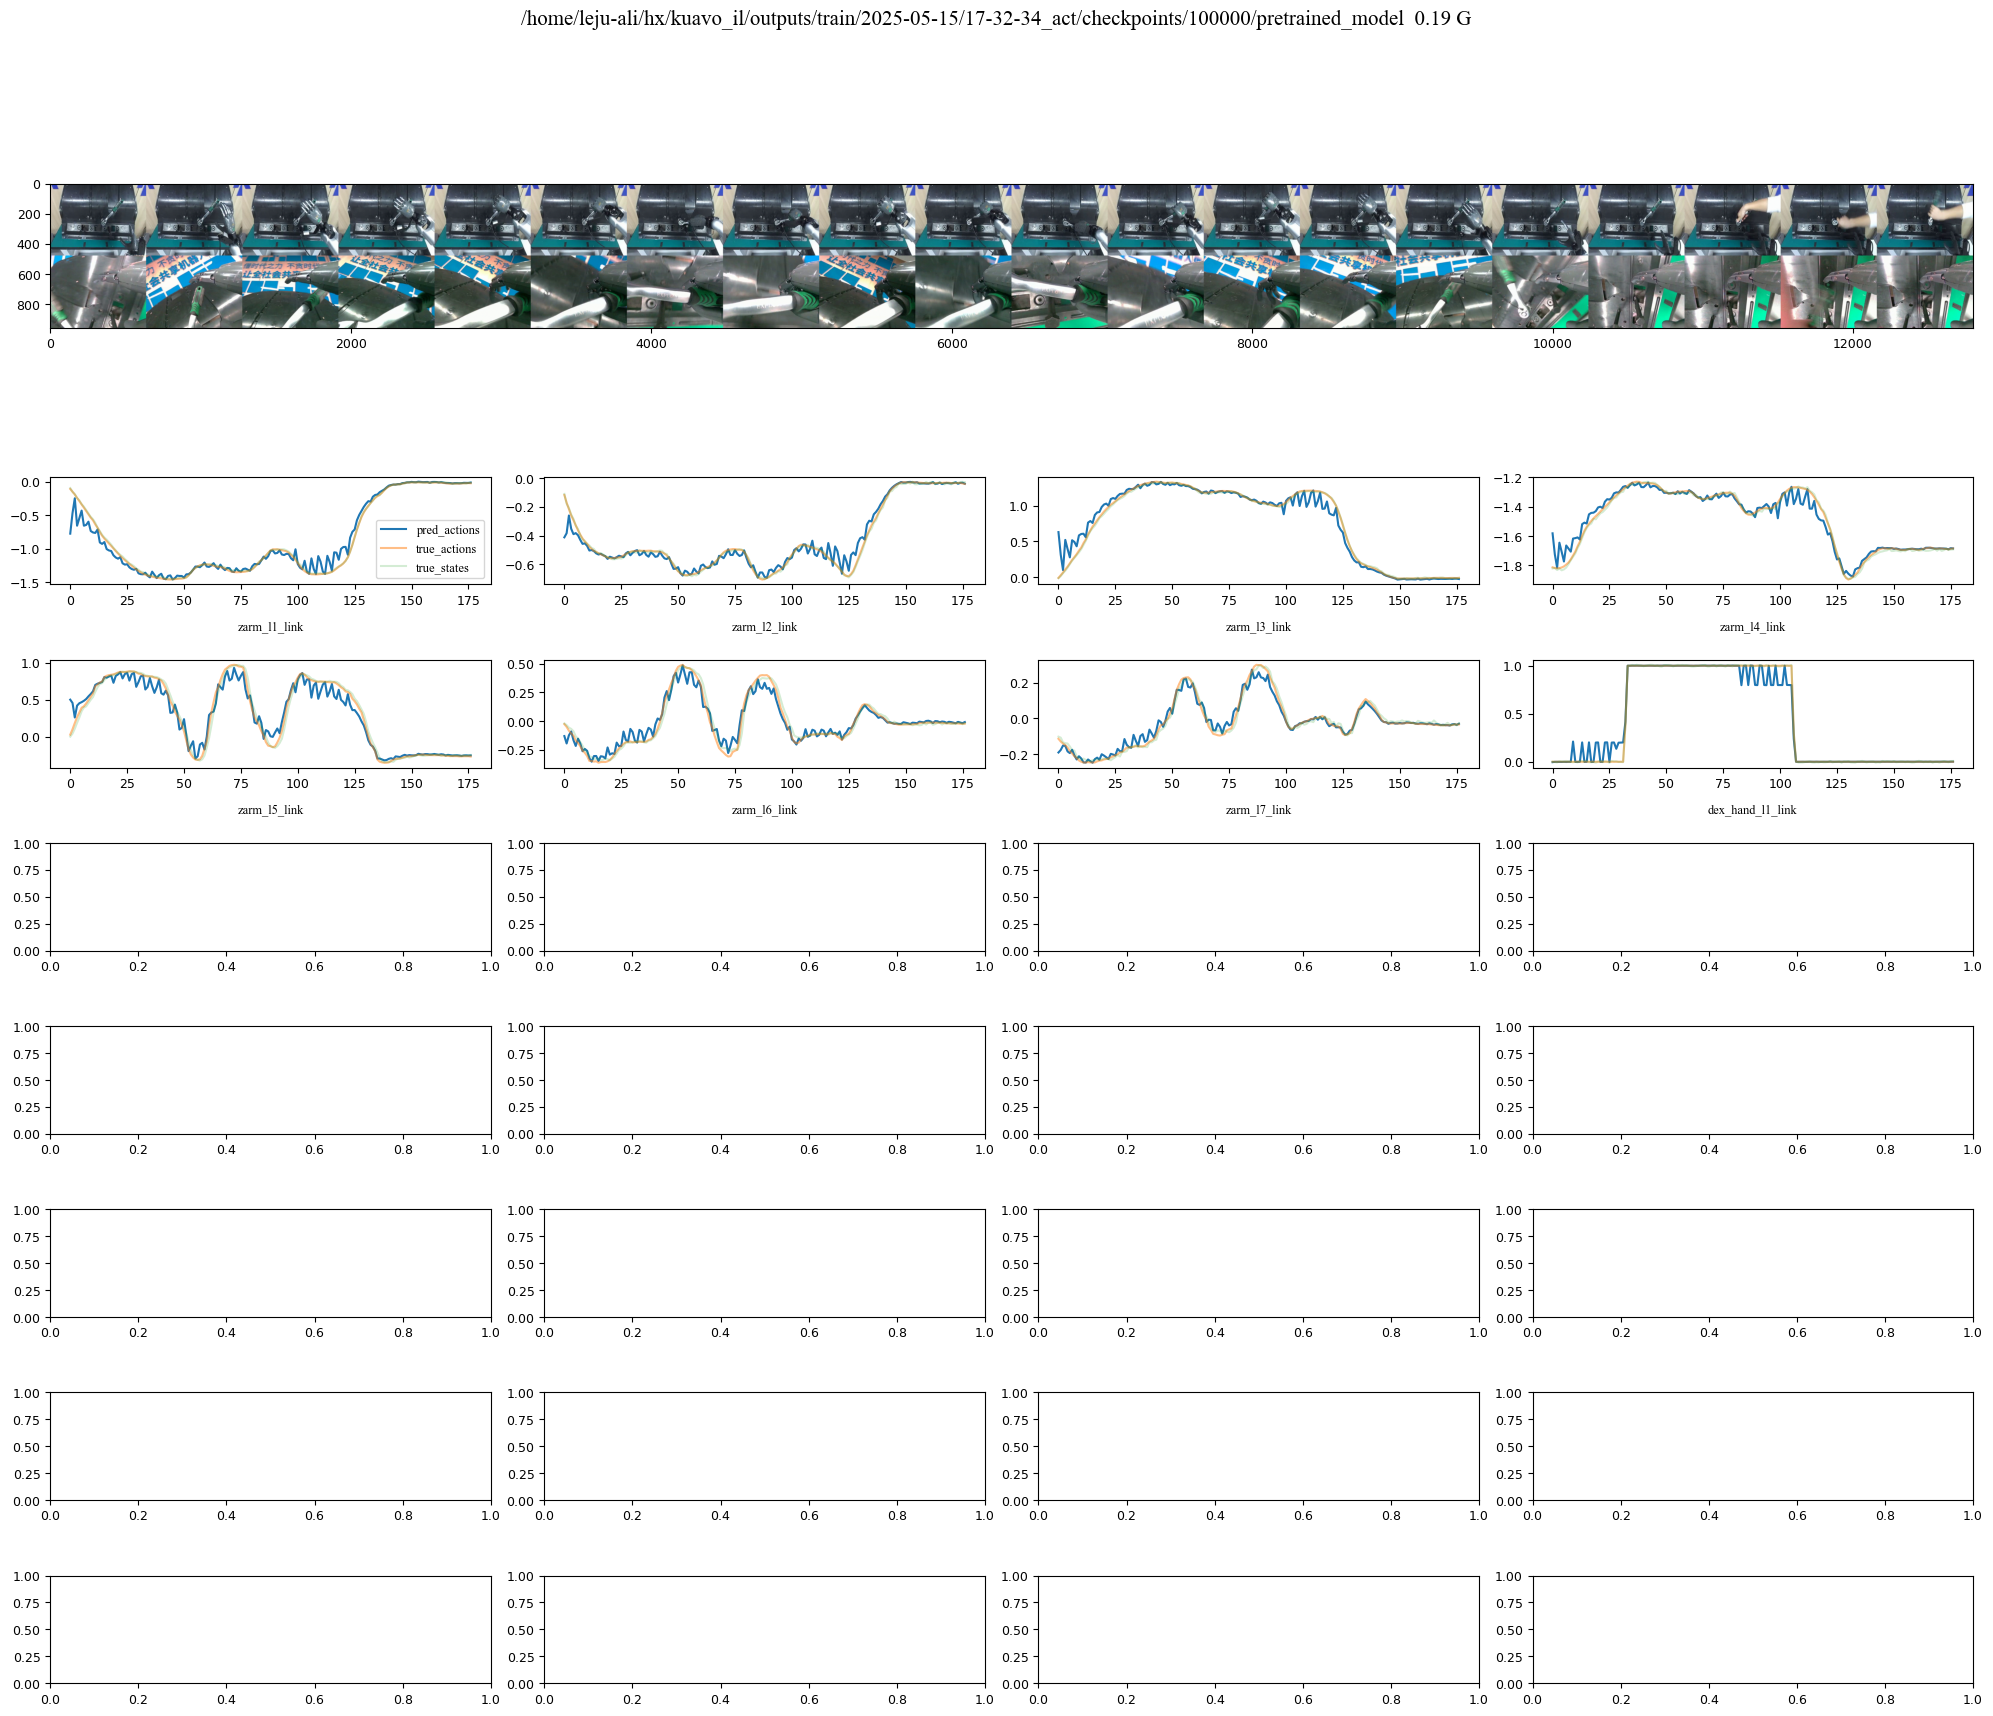

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

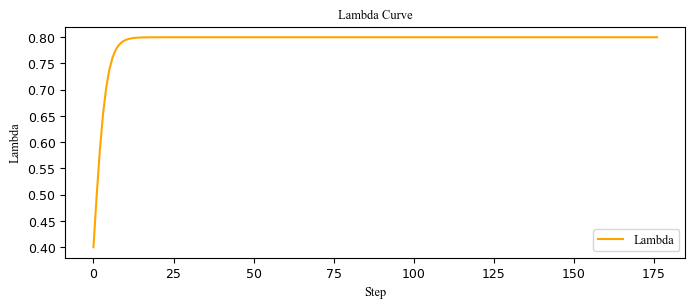

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

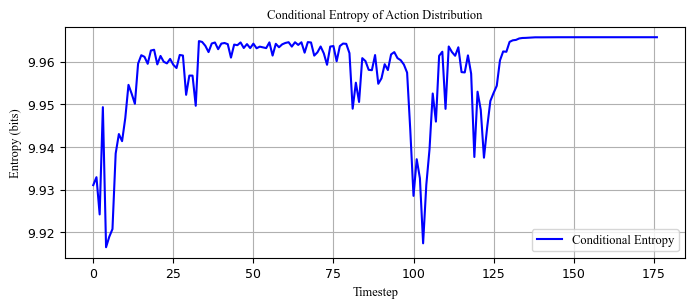

In [130]:
from plot import draw_predicted_result

task_name = ckpt_path + '  ' + f"{ckpt_size:.2f} G"
slc = [(0, 0), (0, 8)]
for eps_idx in range(0, len(next(iter(all_img.values())))):
    draw_predicted_result(task_name, all_img, upBody_lowDim, eps_idx, slice_idx=slc)
    break

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

Best lambda_max: 1.000, Minimum Mean Squared Error: 0.004016


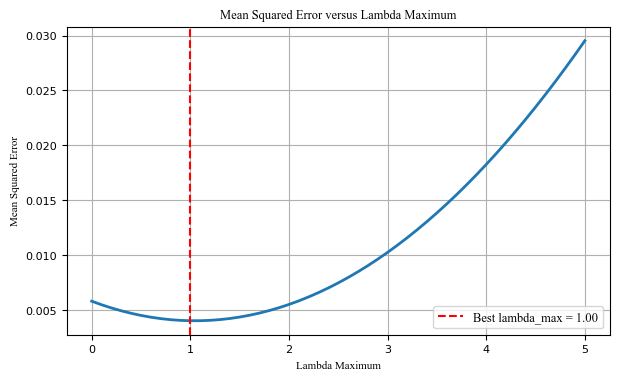

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# 强制指定 Times New Roman 字体路径
times_path = "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf"
prop = font_manager.FontProperties(fname=times_path)



# 以第一个 episode 为例
pred = np.array(upBody_lowDim["pred_actions"][0]).squeeze()
gt = np.array(upBody_lowDim["true_actions"][0]).squeeze()

if pred.ndim == 3:
    pred = pred[:,0,:]

lambda_max_list = np.linspace(0, 5, 51)
mse_list = []

for lambda_max in lambda_max_list:
    steps = np.arange(pred.shape[0])
    k = 0.5
    t0 = 100
    lamdas = lambda_max * (1 / (1 + np.exp(-k * (steps - t0))))
    lamdas = np.clip(lamdas, 0, lambda_max)
    fused = (1 - lamdas[:, None]) * pred + lamdas[:, None] * gt
    mse = np.mean((fused - gt) ** 2)
    # 增加一点噪声让曲线更有波动
   
    mse_list.append(mse)

# 找出最优 lambda_max
min_idx = np.argmin(mse_list)
best_lambda_max = lambda_max_list[min_idx]
best_mse = mse_list[min_idx]
print(f"Best lambda_max: {best_lambda_max:.3f}, Minimum Mean Squared Error: {best_mse:.6f}")

plt.figure(figsize=(7,4))
plt.plot(lambda_max_list, mse_list, linewidth=2)
plt.axvline(best_lambda_max, color='r', linestyle='--', label=f'Best lambda_max = {best_lambda_max:.2f}')
plt.xlabel('Lambda Maximum', fontsize=8, fontproperties=prop)
plt.ylabel('Mean Squared Error', fontsize=8, fontproperties=prop)
plt.title('Mean Squared Error versus Lambda Maximum', fontsize=8, fontproperties=prop)
plt.legend(prop=prop)
plt.tick_params(labelsize=8)
plt.grid(True)
plt.show()

In [132]:
import numpy as np
import pandas as pd

# 假设你只保存第一个 episode 的 predicted actions
pred_actions = np.array(upBody_lowDim["pred_actions"][0]).squeeze()

# 如果 pred_actions 是三维的，通常 shape 为 (step, 1, dim)，先去掉 axis=1
if pred_actions.ndim == 3:
    pred_actions = pred_actions[:, 0, :]

# 保存为 CSV
save_path = "/home/leju-ali/luyuang/predicted_actions.csv"
df = pd.DataFrame(pred_actions)
df.to_csv(save_path, index=False)
print(f"Predicted actions saved to {save_path}")

Predicted actions saved to /home/leju-ali/luyuang/predicted_actions.csv


In [133]:
import numpy as np
import pandas as pd

# 导出第一个 episode 的 entropy
entropy = np.array(upBody_lowDim["entropy"][0]).squeeze()

# 保存为 xlsx 文件
save_path = "/home/leju-ali/luyuang/entropy.xlsx"
df = pd.DataFrame(entropy, columns=["entropy"])
df.to_excel(save_path, index=False)
print(f"Entropy saved to {save_path}")

Entropy saved to /home/leju-ali/luyuang/entropy.xlsx
